# Model development

In this notebook we developed the return prediction model, using an LSTM-based neural network.

### Imports

In [1]:
import pandas as pd
import datetime as dt
import random
import numpy as np
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split


Enabling CUDA, for training the model on the GPU

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

### Reading and converting the dataframe

In [5]:
df = pd.read_csv('data/stock_data.csv')

Converting dataframe to a multi-column yfinance-like df

In [ ]:
def convert_csv_df_to_yf_df(csv_df):
    """Convert a CSV DataFrame to a format similar to Yahoo Finance DataFrame.
    The CSV DataFrame should have 'Date', 'Ticker', 'Open', 'High', 'Low', 'Close', and 'Volume' columns.
    """    


    csv_df['Date'] = pd.to_datetime(csv_df['Date'])


    price_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

   
    multi_df = csv_df.pivot_table(index='Date', columns='Ticker', values=price_cols)

    multi_df = multi_df.sort_index(axis=1)

    multi_df.columns.names = ['Price', 'Ticker']

    return multi_df


In [7]:
df = convert_csv_df_to_yf_df(df)
df = df['Close']

C:\Users\mario\AppData\Local\Temp\ipykernel_26888\132587994.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  csv_df['Date'] = pd.to_datetime(csv_df['Date'])


Only keeping certain stocks

In [8]:
with open('data/stock_tickers.txt', 'r') as f:
    tickers = f.read().splitlines()
tickers = [ticker.replace('\n', '') for ticker in tickers]

df = df[[col for col in tickers if col in df.columns]]

In [9]:
df.head()

Ticker,COST,NVDA,CRM,CL,AXP,PHG,MSFT,AMD,JPM,PG,...,MCD,NKE,CROX,ADBE,KO,JWN,TM,MA,HLT,DIS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00-05:00,30.799129,0.894729,NaN,18.733959,33.198849,19.158504,36.205605,15.500,24.239759,28.608177,...,22.186100,4.670587,NaN,16.274675,14.781797,7.168196,72.034958,NaN,NaN,23.115253
2000-01-04 00:00:00-05:00,29.112101,0.870838,NaN,18.244921,31.945318,17.986570,34.982552,14.625,23.707901,28.057699,...,21.731176,4.415828,NaN,14.909399,14.798185,6.889823,68.697418,NaN,NaN,24.469282
2000-01-05 00:00:00-05:00,29.609568,0.842169,NaN,17.624212,31.133947,18.572540,35.351418,15.000,23.561562,27.523903,...,22.081120,4.670587,NaN,15.204172,14.929290,6.768033,68.975548,NaN,NaN,25.484812
2000-01-06 00:00:00-05:00,30.204361,0.787218,NaN,17.586590,31.768240,17.392117,34.167198,16.000,23.896061,28.791676,...,21.766169,4.646325,NaN,15.328290,14.945670,7.098604,62.856750,NaN,NaN,24.469282
2000-01-07 00:00:00-05:00,32.205006,0.800359,NaN,18.639912,32.230747,18.513096,34.613720,16.250,24.335098,31.093674,...,22.326080,4.646325,NaN,16.072987,15.928943,7.098604,63.783829,NaN,NaN,24.082417


Cutting off dates that are too old (when certain stocks weren't listed yet)

In [10]:
df.index = pd.to_datetime(df.index, utc=True).tz_convert(None)
df.index = df.index.normalize()


In [11]:
start_date = dt.datetime(2014, 1, 1)
end_date = dt.datetime(2023, 1, 1)

In [12]:
stock_df = df.loc[start_date:end_date]

In [13]:
stock_df.isnull().sum()

Ticker
COST     0
NVDA     0
CRM      0
CL       0
AXP      0
PHG      0
MSFT     0
AMD      0
JPM      0
PG       0
GOOGL    0
LOGI     0
DAL      0
UBSFY    0
AMZN     0
UL       0
JNJ      0
HSY      0
FDX      0
AEO      0
SBUX     0
V        0
MAR      0
FL       0
CSCO     0
TSLA     0
NFLX     0
HMC      0
LUV      0
POAHY    0
AAPL     0
HD       0
CMG      0
TGT      0
NTDOY    0
LVMUY    0
MMM      0
ADDYY    0
MCD      0
NKE      0
CROX     0
ADBE     0
KO       0
JWN      0
TM       0
MA       0
HLT      0
DIS      0
dtype: int64

In [14]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2266 entries, 2014-01-02 to 2022-12-30
Data columns (total 48 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   COST    2266 non-null   float64
 1   NVDA    2266 non-null   float64
 2   CRM     2266 non-null   float64
 3   CL      2266 non-null   float64
 4   AXP     2266 non-null   float64
 5   PHG     2266 non-null   float64
 6   MSFT    2266 non-null   float64
 7   AMD     2266 non-null   float64
 8   JPM     2266 non-null   float64
 9   PG      2266 non-null   float64
 10  GOOGL   2266 non-null   float64
 11  LOGI    2266 non-null   float64
 12  DAL     2266 non-null   float64
 13  UBSFY   2266 non-null   float64
 14  AMZN    2266 non-null   float64
 15  UL      2266 non-null   float64
 16  JNJ     2266 non-null   float64
 17  HSY     2266 non-null   float64
 18  FDX     2266 non-null   float64
 19  AEO     2266 non-null   float64
 20  SBUX    2266 non-null   float64
 21  V       2266 non-nu

In [15]:
stock_df.tail()

Ticker,COST,NVDA,CRM,CL,AXP,PHG,MSFT,AMD,JPM,PG,...,MCD,NKE,CROX,ADBE,KO,JWN,TM,MA,HLT,DIS
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-23,460.015564,152.005920,129.440002,77.959312,145.472549,14.91,237.112091,64.519997,128.420670,149.780884,...,263.214172,115.152916,103.000000,338.450012,62.855492,16.518147,137.139999,342.011322,126.041359,88.010002
2022-12-27,455.889191,141.159790,130.660004,78.440125,144.849182,14.90,235.354095,63.270000,128.870667,151.086151,...,262.496033,116.450554,107.970001,335.089996,63.239597,16.093365,136.160004,344.559509,125.353485,86.370003
2022-12-28,450.410553,140.310074,128.470001,77.341133,142.494217,14.65,232.940552,62.570000,129.574982,149.133179,...,260.794189,113.894913,105.169998,328.329987,62.609272,15.166574,134.130005,340.368958,123.638763,84.169998
2022-12-29,453.930420,145.978073,132.539993,77.880821,145.769394,15.25,239.376648,64.820000,130.318420,149.751434,...,261.600861,116.242538,107.690002,337.579987,62.983532,15.533429,137.410004,346.600006,125.652557,87.180000
2022-12-30,453.900543,146.088028,132.589996,77.311699,146.194855,14.99,238.194717,64.769997,131.179276,148.740601,...,259.239929,115.905754,108.430000,336.529999,62.648666,15.581699,136.580002,346.122253,125.971581,86.879997


### Creating training data

Generating random portofolios

In [ ]:
def generate_random_portfolio(
    tickers,
    min_stocks=1,
    max_stocks=10,
):
    # Select random stocks from the list and assign random weights
   
    stocks_count = random.randint(min_stocks, max_stocks) 
  
    stocks_list = random.sample(tickers, stocks_count)


    raw_weights = np.random.uniform(0.1, 1.0, stocks_count)
    stocks_weights = (raw_weights / np.sum(raw_weights)).tolist()
    stocks_weights = [round(weight, 3) for weight in stocks_weights]

    # Make sure weights sum to exactly 1, if not, add the difference to the first weight
    diff = 1 - sum(stocks_weights)
    stocks_weights[0] += diff  

    
    portfolio = {
        "stocks": stocks_list,
        "weights": stocks_weights,
    }

    return portfolio

In [17]:
portofolios = []
for i in range(120):
    portfolio = generate_random_portfolio(tickers, 1, 10) 
    portofolios.append(portfolio)


Preparing the data before feeding it into the LSTM

In [ ]:
def get_portofolio_returns(portofolio):
    """Calculate the returns of a portfolio based on its weights and stock prices."""


    stock_prices = stock_df[portofolio['stocks']]

    # Calculate daily returns for each stock
    daily_returns = stock_prices.pct_change().dropna()

    # Calculate weighted returns for the whole portfolio
    weighted_returns = daily_returns.dot(portofolio['weights'])

    return weighted_returns

In [ ]:
def create_lstm_dataset(data, lookback=30):
    # Transforms time series data into a supervised learning dataset for LSTM.
    import numpy as np

    if isinstance(data, pd.Series):
        data = data.to_frame()

    values = data.values
    # X will contain sequences of 'lookback' time steps, y will contain the next time step value.
    X, y = [], []

    for i in range(len(values) - lookback):
        X.append(values[i:i+lookback])
        y.append(values[i+lookback][0])  

    return np.array(X), np.array(y)


In [20]:
X, Y = [], []
for portfolio in portofolios:
    weighted_returns = get_portofolio_returns(portfolio)
    temp_x, temp_y = create_lstm_dataset(weighted_returns)
    X.append(temp_x)
    Y.append(temp_y)
X = np.concatenate(X, axis=0)
Y = np.concatenate(Y, axis=0)

In [21]:
X.shape, Y.shape

((268200, 30, 1), (268200,))

We need to check the distribution of our returns, to see if we need to normalize it. Usually, they should be centered around 0, but we need to see if it applies to our values as well

Mean of target returns (Y): 0.000682


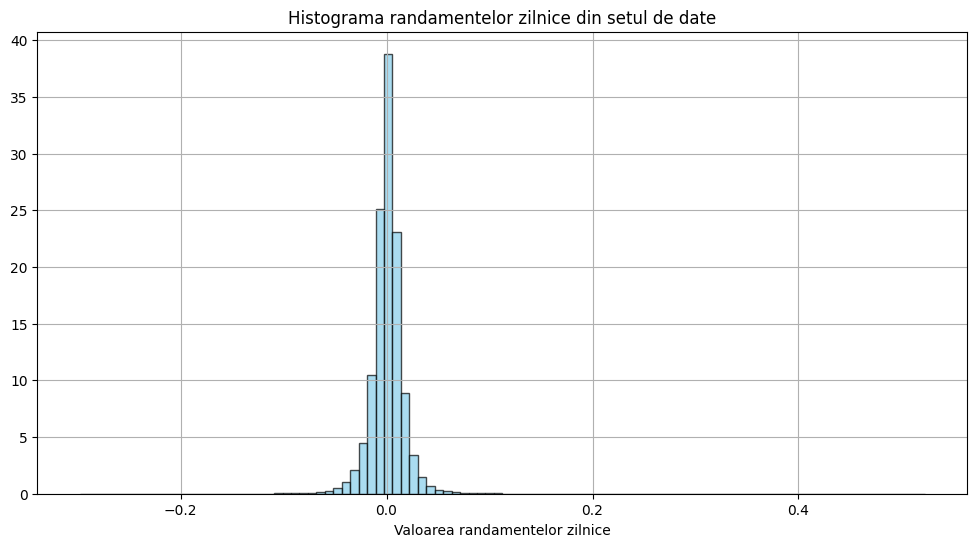

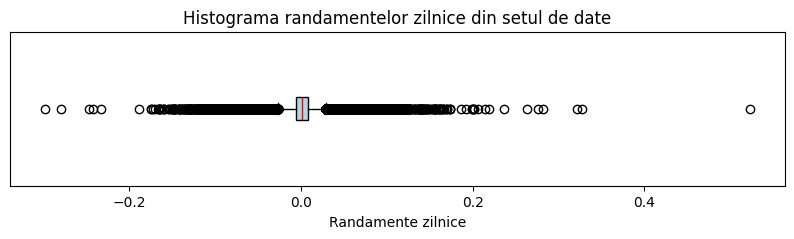

1st percentile of target returns (Y): -0.043710
99th percentile of target returns (Y): 0.043237


In [ ]:

import numpy as np
import matplotlib.pyplot as plt


all_target_returns = Y.flatten()

 
mean_target_returns = np.mean(all_target_returns)

print(f"Mean of target returns (Y): {mean_target_returns:.6f}")

 

plt.figure(figsize=(12, 6))

 
plt.hist(all_target_returns, bins=100, density=True, alpha=0.7, color='skyblue', edgecolor='black')


plt.title('Histograma randamentelor zilnice din setul de date')
plt.xlabel('Valoarea randamentelor zilnice')
 
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 2))
plt.boxplot(all_target_returns, vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red'))
plt.title('Histograma randamentelor zilnice din setul de date')
plt.xlabel('Randamente zilnice')
plt.yticks([]) 
plt.show()


p1_y = np.percentile(all_target_returns, 1)
p99_y = np.percentile(all_target_returns, 99)
print(f"1st percentile of target returns (Y): {p1_y:.6f}")
print(f"99th percentile of target returns (Y): {p99_y:.6f}")


The returns are well distributed and they don't need any normalization

In [23]:

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=True, random_state=42
)

### LSTM

We will define and train the LSTM returns prediction model 

In [ ]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):

    LOOKBACK = 30

    def __init__(self, input_size=1, hidden_layer_size=50, intermediate_size=10, output_size=1):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(hidden_layer_size, intermediate_size)
        self.relu = nn.LeakyReLU()

        self.fc2 = nn.Linear(intermediate_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        last_time_step = lstm_out[:, -1, :]

        hidden_out = self.relu(self.fc1(last_time_step))
        output = self.fc2(hidden_out)

        return output


In [25]:
# Initialize the model
model = LSTMModel().to(device)




C:\Users\mario\AppData\Roaming\Python\Python313\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [26]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [27]:
X_train_tensor.shape

torch.Size([214560, 30, 1])

In [ ]:
 
loss_function = nn.MSELoss()   
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 200
batch_size = 64
val_batch_size = 64  

train_rmses = []
val_rmses = []


for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.size(0))

    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        predictions = model(batch_x)
        loss = loss_function(predictions, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, X_val_tensor.size(0), val_batch_size):
            val_indices = torch.arange(i, min(i + val_batch_size, X_val_tensor.size(0)))
            batch_val_x, batch_val_y = X_val_tensor[val_indices], y_val_tensor[val_indices]

            val_predictions = model(batch_val_x)
            val_loss += loss_function(val_predictions, batch_val_y.unsqueeze(1)).item()

    avg_val_loss = val_loss / (X_val_tensor.size(0) // val_batch_size)


    rmse_train = loss.item() ** 0.5
    rmse_val = avg_val_loss ** 0.5
    current_lr = optimizer.param_groups[0]['lr']

    train_rmses.append(rmse_train)
    val_rmses.append(rmse_val)


    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, RMSE Train: {rmse_train:.4f}, RMSE Val: {rmse_val:.4f}")


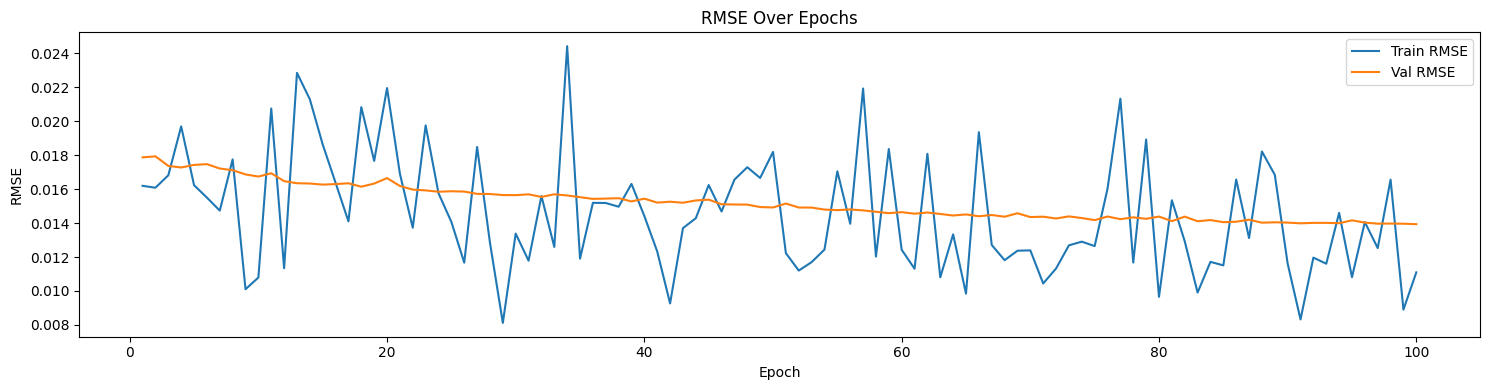

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(15, 4))


plt.plot(epochs_range, train_rmses, label='Train RMSE')
plt.plot(epochs_range, val_rmses, label='Val RMSE')
plt.title('RMSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()



plt.tight_layout()
plt.show()


### Visualize predictions

In [ ]:
test_returns = get_portofolio_returns(generate_random_portfolio(tickers, 1, 10))

In [ ]:
test_returns.head()

Date
2014-01-03   -0.000747
2014-01-06   -0.001932
2014-01-07    0.002605
2014-01-08    0.002907
2014-01-09   -0.000815
dtype: float64

In [ ]:
import numpy as np

# Create sequences from the returns data
def create_sequences(data, lookback):
    sequences = []
    labels = []
    for i in range(lookback, len(data)):
        sequences.append(data[i-lookback:i])  
        labels.append(data[i]) 
    return np.array(sequences), np.array(labels)

LOOKBACK = 30   

 
returns = test_returns.values  
X_new, y_new = create_sequences(returns, LOOKBACK)   

# Convert to PyTorch tensors
X_new_tensor = torch.tensor(X_new, dtype=torch.float32).unsqueeze(-1).to(device)
y_new_tensor = torch.tensor(y_new, dtype=torch.float32).to(device)


In [ ]:
y_train.shape

(211228,)

In [ ]:
print(torch.version.cuda)

11.8


In [ ]:
# Set the model to evaluation mode
model.eval()

# Make predictions with the model
with torch.no_grad():
    predictions = model(X_new_tensor).squeeze().cpu().numpy()
    actuals = y_new_tensor.cpu().numpy()


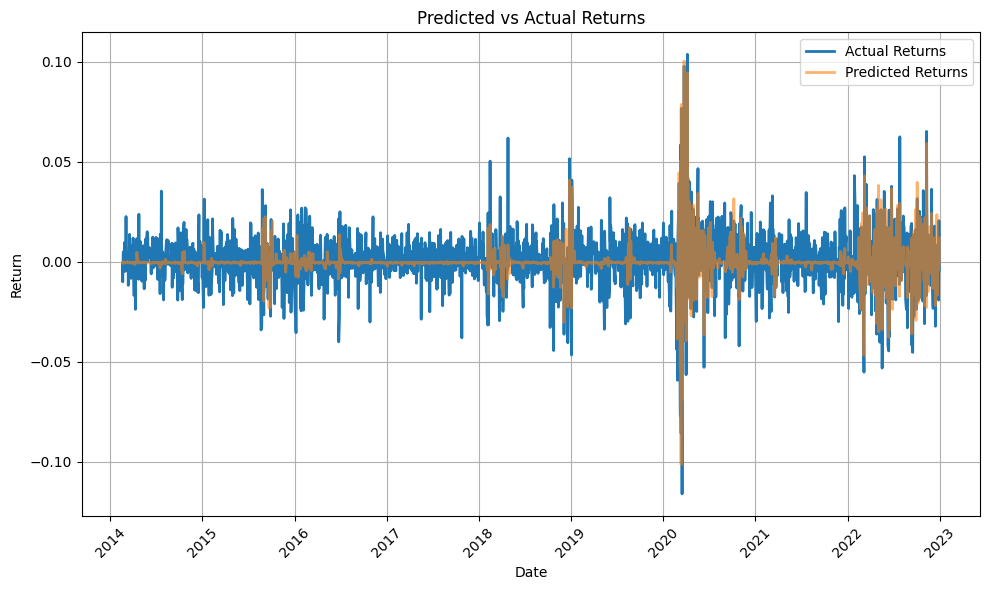

In [ ]:
import matplotlib.pyplot as plt

dates = test_returns.index[LOOKBACK:].values

plt.figure(figsize=(10, 6))
plt.plot(dates, actuals, label='Actual Returns', linewidth=2, color='#1f77b4')  # Blue
plt.plot(dates, predictions, label='Predicted Returns', linewidth=2, color='#ff7f0e', alpha=0.6)  # Orange, transparent
plt.title('Predicted vs Actual Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We can notice that our model did manage to catch the big spikes in 2020, but it otherwise gives outputs that are really close to the mean

### Other Model Results

def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)

        # Added intermediate dense layer with 3 nodes
        self.hidden = nn.Linear(hidden_layer_size, 3)
        self.relu = nn.ReLU()

        self.fc = nn.Linear(3, output_size)

lookback_period=20  RMSE Val: 0.0174  
lookback_period=30  RMSE Val: 0.0160  
lookback_period=50  RMSE Val: 0.0172

---

import torch
import torch.nn as nn

class LSTMModel(nn.Module):

    LOOKBACK = 30

    def __init__(self, input_size=1, hidden_layer_size=100, intermediate_size=20, output_size=1):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)

        # First dense layer after LSTM
        self.fc1 = nn.Linear(hidden_layer_size, intermediate_size)
        self.relu = nn.LeakyReLU()

        # Second dense layer for final output
        self.fc2 = nn.Linear(intermediate_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        last_time_step = lstm_out[:, -1, :]

        hidden_out = self.relu(self.fc1(last_time_step))
        output = self.fc2(hidden_out)

        return output


RMSE Val: 0.0148

---


class LSTMModel(nn.Module):

    LOOKBACK = 30

    def __init__(
        self, input_size=1, hidden_layer_size=50, intermediate_size=10, output_size=1
    ):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(hidden_layer_size, intermediate_size)
        self.relu = nn.LeakyReLU()

        self.fc2 = nn.Linear(intermediate_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        last_time_step = lstm_out[:, -1, :]

        hidden_out = self.relu(self.fc1(last_time_step))
        output = self.fc2(hidden_out)

        return output


RMSE Val: 0.0123 - 133 epochs

### Saving the model

In [ ]:
save_model = False

if save_model:
    torch.save(model.state_dict(), 'model/lstm_model2.pth')
    print("Model saved to 'model/lstm_model2.pth'")